In [1]:
library(tidyverse)
library(readr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [10]:
# Read both datasets
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
glimpse(players)
glimpse(sessions)


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

In [12]:
# Clean sessions data
sessions <- sessions |>
  rename(
    player = hashedEmail,
    start  = start_time,
    end    = end_time
  ) |>
  mutate(
    start    = ymd_hms(start),
    end      = ymd_hms(end),
    duration = as.numeric(difftime(end, start, units = "mins"))
  ) |>
  filter(!is.na(duration), duration > 0)

In [13]:
# Clean players data
players <- players |>
  rename(player = hashedEmail) |>
  mutate(
    Age          = as.numeric(Age),
    played_hours = as.numeric(played_hours),
    subscribe    = subscribe == "TRUE"
  )

In [15]:
# Computing mean
players_means <- players |>
  summarise(across(where(is.numeric), ~ mean(.x, na.rm = TRUE)))

players_means

played_hours,Age
<dbl>,<dbl>
5.845918,21.13918


In [16]:
# Merge data
merged_data <- left_join(sessions, players, by = "player")


In [17]:
# Summary of early gameplay

player_summary <- merged_data |>
  group_by(player) |>
  summarise(
    first_day            = min(as.Date(start)),
    num_sessions         = n(),
    avg_session_duration = mean(duration),
    total_playtime       = sum(duration) / 60,
    active_days          = n_distinct(as.Date(start)),
    first_week_days      = n_distinct(as.Date(start)[as.Date(start) <= first_day + 7])
  )

In [19]:
# Define top 25% high contributors

cutoff <- quantile(player_summary$total_playtime, 0.75, na.rm = TRUE)
player_summary <- player_summary |>
  mutate(high_contributor = total_playtime >= cutoff)

In [20]:
# Combine summaries with player characteristics
analysis_data <- left_join(player_summary, players, by = "player")


In [21]:
# Summary table comparing groups
group_summary <- analysis_data |>
  group_by(high_contributor) |>
  summarise(
    mean_sessions   = mean(num_sessions),
    mean_playtime   = mean(total_playtime),
    mean_duration   = mean(avg_session_duration),
    mean_firstweek  = mean(first_week_days),
    n_players       = n()
  )

group_summary

high_contributor,mean_sessions,mean_playtime,mean_duration,mean_firstweek,n_players
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,1.387097,7.258065e-03,3.533806e-01,1,93
TRUE,43.781250,2.437304e+04,5.374526e+04,1,32


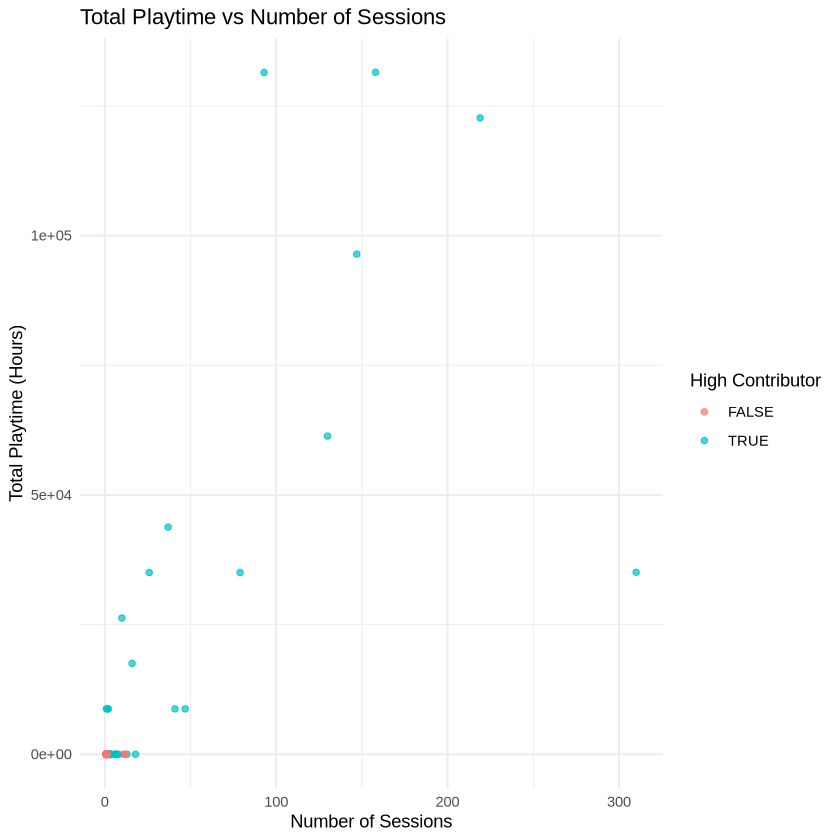

In [33]:
# Visuals --> sessions vs playtime
graph1 <- ggplot(analysis_data,
       aes(x = num_sessions, y = total_playtime, colour = high_contributor)) +
  geom_point(alpha = 0.7) +
  labs(
    title = "Total Playtime vs Number of Sessions",
    x = "Number of Sessions",
    y = "Total Playtime (Hours)",
    colour = "High Contributor"
  ) +
  theme_minimal()
graph1

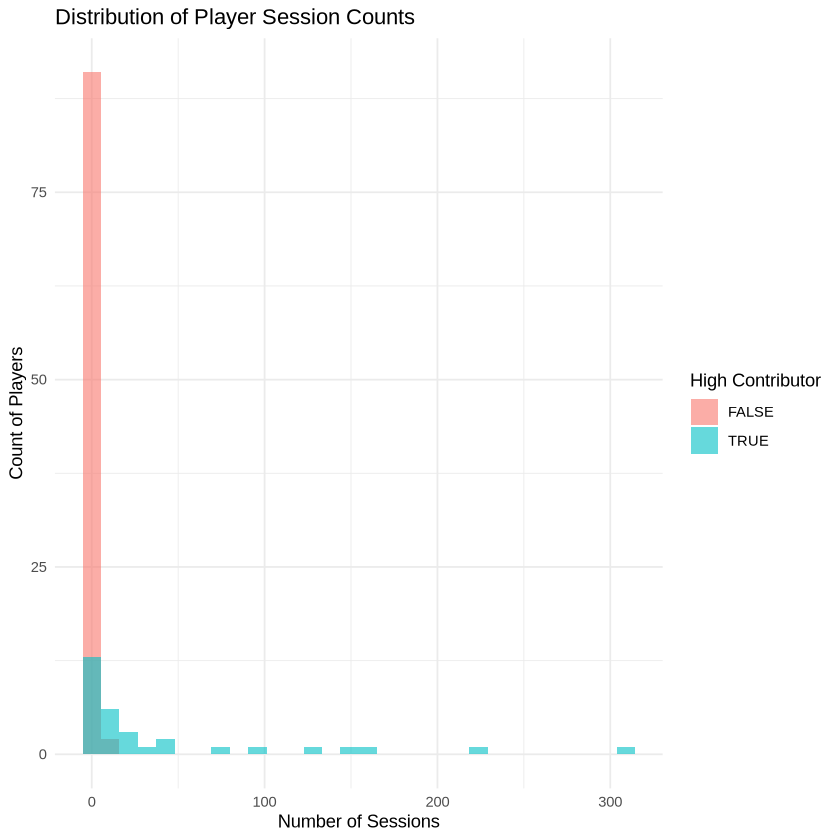

In [34]:
# Visual --> distribution of number of sessions
graph2 <- ggplot(analysis_data, aes(x = num_sessions, fill = high_contributor)) +
  geom_histogram(bins = 30, alpha = 0.6, position = "identity") +
  labs(
    title = "Distribution of Player Session Counts",
    x = "Number of Sessions",
    y = "Count of Players",
    fill = "High Contributor"
  ) +
  theme_minimal()
graph2

*Data Description*

This project uses two datasets from a Minecraft research server: players.csv, which contains demographic and background information for each unique player, and sessions.csv, which records every individual play session. After loading both files, I checked their structure using glimpse() to confirm variable names, formats, and any inconsistencies that needed to be cleaned.

Sessions were converted into a tidy format by renaming columns, parsing timestamps, and calculating session duration in minutes. Invalid or negative durations were removed. In the player data, numeric variables such as age and total hours played were converted to numeric form, while the subscription variable was converted into a logical indicator.

To summarize the player dataset, I computed the mean of every quantitative variable in players.csv:

In [25]:
knitr::kable(players_means, digits = 2)




| played_hours|   Age|
|------------:|-----:|
|         5.85| 21.14|

*Question*

I selected the second broad question from the rubric, focusing on identifying which types of players contribute the most gameplay data. My specific question is:

- Can early activity indicators—such as number of sessions, average session duration, and active days in the first week—predict whether a player becomes a high data contributor?

I define “high contributors” as players in the top 25% of total playtime. Using the 75th percentile instead of the mean creates a clear, robust cutoff that is less sensitive to extreme outliers in heavy playtime.

In [26]:
cutoff
table(player_summary$high_contributor)


75% 
0.03194444


FALSE  TRUE 
   93    32 

*Exploration and Visualization*

To understand the relationship between early behaviour and total playtime, I created player-level summaries including session count, average session duration, active days, and first-week activity. These were merged with demographic variables to allow comparisons across groups.

A summary table shows strong differences between the two groups: high contributors have far more sessions, significantly longer total playtime, and more active days even in the first week.

In [28]:
knitr::kable(group_summary, digits = 2)




|high_contributor | mean_sessions| mean_playtime| mean_duration| mean_firstweek| n_players|
|:----------------|-------------:|-------------:|-------------:|--------------:|---------:|
|FALSE            |          1.39|          0.01|          0.35|              1|        93|
|TRUE             |         43.78|      24373.04|      53745.26|              1|        32|

Two visualizations illustrate these trends. A scatter plot of total playtime versus session count shows a clear separation—high contributors cluster at the high end of both variables. A histogram of total sessions shows that most players are casual, while high contributors fall in a long right tail.

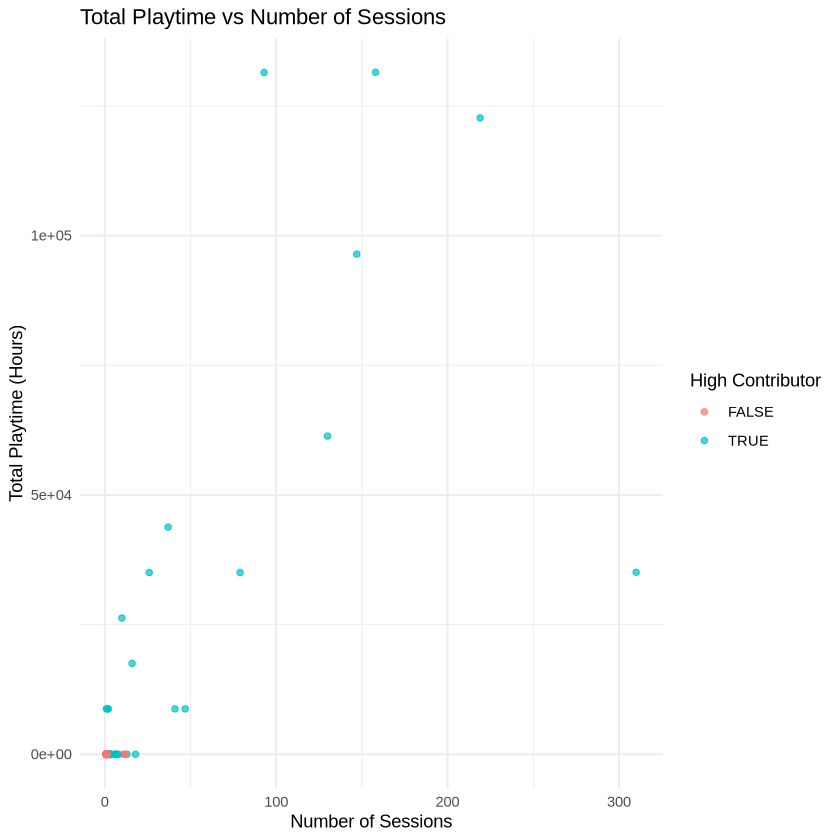

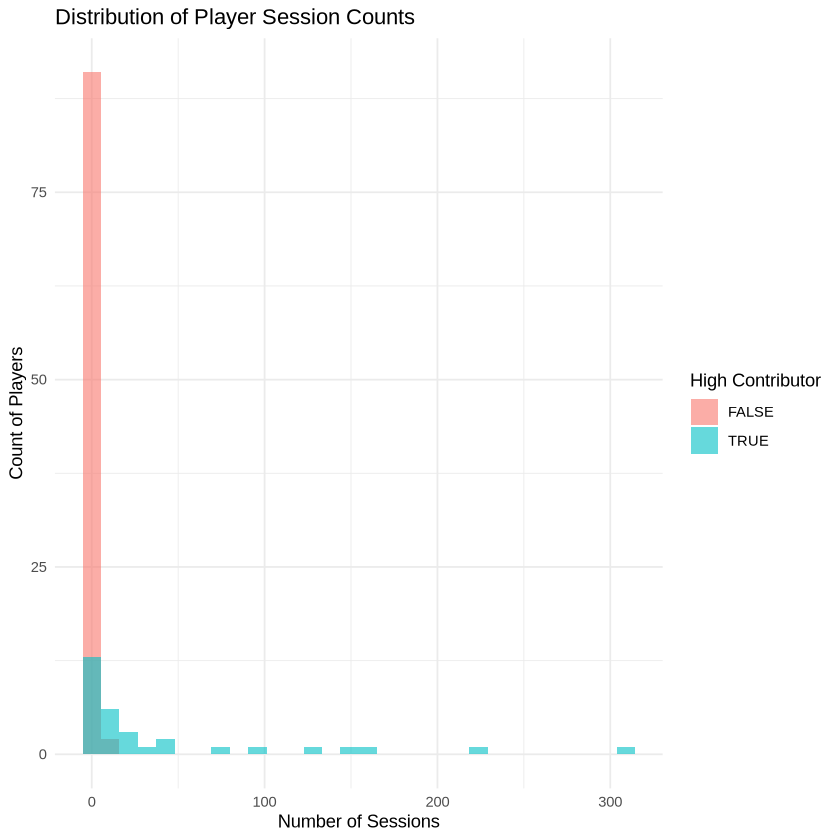

In [35]:
graph1
graph2

*Methods and Plan*

For the final project, I plan to use k-nearest neighbours classification to predict whether a player becomes a high contributor. This method is appropriate because it makes few assumptions, handles nonlinear relationships, and is fully covered in the DSCI 100 textbook. I will use early activity variables as predictors and the high-contributor indicator as the response.

The data will be split into 80% training and 20% testing, with cross-validation on the training set to select the optimal number of neighbours. Model comparison will be based on accuracy and especially recall for high contributors, as identifying these players correctly is the main goal.